# What Predicts the Best Data Science Salaries?
*Logistic Regression & Best Predictor of Data Science Salaries | Project 4 in General Assembly's DSI*

##### Description

From the job search aggregator, Indeed.com, I scrapped key data points from over 2700 jobs across six cities: Sydney, Melbourne, San Francisco, New York, Newark and Chicago. The resulting datasets were collated, cleaned and stored in the pandas DataFrame 'jobs', which was used to identify what feature is the best predictor of salary. 

The results of the logistic regression indicate that there are few features acting as valid predictors. Specifically, words from job titles or job descriptions are the most accurate predictors, but only for the lowest salary bin. 

##### Contents

* Import scrapped data
* Further clean data
* Convert salaries into USD
* Explore shape of dataset
* Select optimal bins for salaries
* Logistical Regression and results
* Key word analysis 


In [137]:
%matplotlib inline
import requests
import urllib2
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import psycopg2
import string

### Import Scrapped Data

In [138]:
jobs = pd.read_csv('./job_searches.csv')
nyc_jobs = pd.read_csv('new_job_searches.csv')
chi_jobs = pd.read_csv('chi_job_searches.csv')

In [139]:
print jobs.shape
print nyc_jobs.shape

(1326, 16)
(1078, 16)


In [140]:
jobs = jobs.append(nyc_jobs)
jobs = jobs.append(chi_jobs)

In [141]:
jobs.shape

(2713, 16)

### Further Clean Data

In [142]:
print jobs.shape
jobs.drop(labels=['salary_bins', 'salary', 'job_posted'], axis=1, inplace=True)
jobs.info()

(2713, 16)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2713 entries, 0 to 308
Data columns (total 13 columns):
company                 2713 non-null object
culture                 2713 non-null object
job_addr                2713 non-null object
job_description         2713 non-null object
job_security_advance    2713 non-null object
job_title               2713 non-null object
link                    2713 non-null object
management              2713 non-null object
reviews_score           2713 non-null float64
reviews_total           2713 non-null object
salary_benefits         2713 non-null object
work_life_bal           2713 non-null object
salary_bins_int         2713 non-null int64
dtypes: float64(1), int64(1), object(11)
memory usage: 296.7+ KB


In [143]:
states=[]

for i in jobs.job_addr:
    if 'CA' in i:
        states.append('CA')
    elif 'NSW' in i:
        states.append('NSW')
    elif 'VIC' in i:
        states.append('VIC')
    elif 'NY' in i:
        states.append('NY')
    elif 'NJ' in i:
        states.append('NJ')
    elif 'IL' in i:
        states.append('IL')
    else:
        states.append('i')
        
jobs['state'] = states

jobs.state.unique()

array(['NSW', 'VIC', 'CA', 'NY', 'NJ', 'IL'], dtype=object)

### Convert to USD

In [144]:
dictionary={'NSW': 0.77, 'VIC': 0.77, 'CA': 1, 'NY': 1, 'NJ': 1, 'IL': 1}
jobs['conversion_to_USD'] = jobs.state.map(dictionary) 
jobs['adj_salary_bin'] = jobs.salary_bins_int*jobs.conversion_to_USD

### Exploratory Analysis

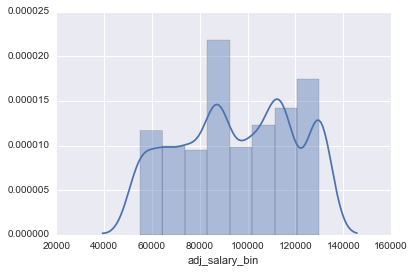

In [145]:
sb.distplot(jobs.adj_salary_bin, bins=8)
plt.show()

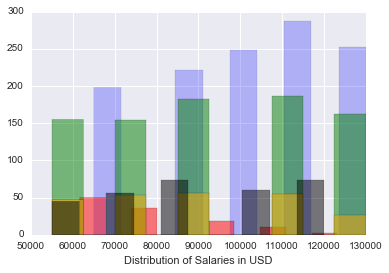

In [146]:
cali = jobs[jobs.state == 'CA']
#nyc = jobs[(jobs.state == 'NY' )& (jobs.state == 'NJ')]
ny = jobs[jobs.state == 'NY']
nj = jobs[jobs.state == 'NJ']
il = jobs[jobs.state == 'IL']
aus = jobs[jobs.conversion_to_USD == 0.77]

plt.hist(cali.adj_salary_bin, color='b', alpha=0.25)
plt.hist(aus.adj_salary_bin, color='r', alpha=0.5)
plt.hist(ny.adj_salary_bin, color='g', alpha=0.5)
plt.hist(nj.adj_salary_bin, color='orange', alpha=0.5)
plt.hist(il.adj_salary_bin, color='black', alpha=0.5)


plt.xlabel('Distribution of Salaries in USD')

plt.show()

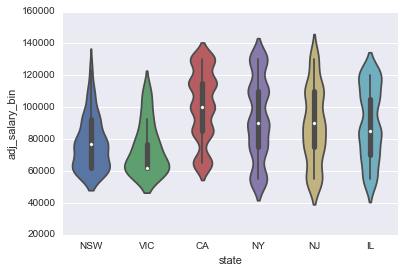

In [147]:
import seaborn as sb
sb.violinplot(x=jobs.state, y=jobs.adj_salary_bin, data=jobs)
plt.show()

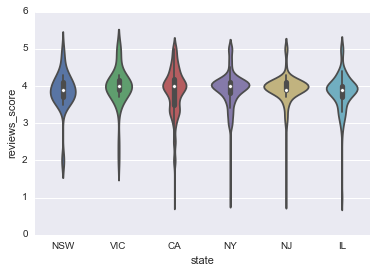

In [148]:
sb.violinplot(x=jobs.state, y=jobs.reviews_score, data=jobs)
plt.show()

### Select Optimal Bins for Salaries

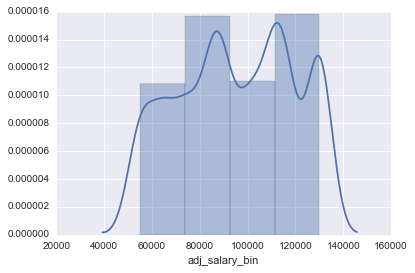

In [149]:
sb.distplot(jobs.adj_salary_bin, bins=4)
plt.show()

In [150]:
jobs['sal_bins'] = pd.cut(jobs.adj_salary_bin, 4, labels=[1,2,3,4])

dictionary = {'NSW':0, 'VIC':1, 'CA':2, 'NY':3, 'NJ':4, 'IL':5}
jobs['state_number'] = jobs.state.map(dictionary)

### Logistic Regression

In [151]:
def LRAccuracyScore(model, X, y, columns):
    
    #Returns a list of results 
    results = []
    
    try:
        scoring = cross_val_score(model,X,y,cv=5,scoring='accuracy')
        score = scoring.mean()
        score_std = scoring.std()
    except:
        score = 'None'
        score_std = 'None'
    
    #Append scores to results
    results.append(score)
    results.append(score_std)
    
    model.fit(X,y)
    
    closed = False
    
    try:
        feature_scores = model.coef_.tolist()
        closed = True
    except:
        pass    
    
    if closed == False:
        try:
            feature_scores = model.estimator_.coef_.tolist()
            closed = True
        except:
            pass
    
    if closed == False:
        try:    
            feature_scores = model.feature_importances_ 
        except:
            feature_scores = ['None'] * len(columns)

    for score in feature_scores:
        results.append(score) 
    
    return results

In [152]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
lr = LogisticRegression()
dummy = DummyClassifier()

In [153]:
tfidf = TfidfVectorizer()
key_words = tfidf.fit_transform(jobs.job_title).toarray()
print jobs.shape
print key_words.shape

(2713, 18)
(2713, 1448)


In [154]:
X=jobs[['state_number', 'reviews_score']]
y = jobs.sal_bins
key_words = pd.DataFrame(key_words)

print 'Logistical Regression Results (state & review score):'
print cross_val_score(lr,X,y,cv=5,scoring='accuracy').mean()
print

lr.fit(X,y)
print lr.coef_
print

print 'Dummy Classifier Results (state & review score):'
print cross_val_score(dummy,X,y,cv=5,scoring='accuracy').mean()
print

print 'Logistical Regression Results (key_words):'
print cross_val_score(lr,key_words,y,cv=5,scoring='accuracy').mean()
print

print 'Dummy Classifier Results(key_words):'
print cross_val_score(dummy,key_words,y,cv=5,scoring='accuracy').mean()
print


Logistical Regression Results (state & review score):
0.363484509509

[[ 0.09140611  0.10891742]
 [ 0.11066979 -0.08034607]
 [ 0.06043498 -0.03449102]
 [-0.2580575  -0.06662397]]

Dummy Classifier Results (state & review score):
0.255784253044

Logistical Regression Results (key_words):
0.41616498305

Dummy Classifier Results(key_words):
0.245508289184



The results indicated that **location** is a better predictor over company review score. Additionally, it looks like these feature have more impact in **lower salary brackets**. I will test both lower salary bins and location. 

### Subset of Lower Salary Bins

In [155]:
jobs_low = jobs[jobs.sal_bins <= 2]
tfidf = TfidfVectorizer()
key_words_low = tfidf.fit_transform(jobs_low.job_title).toarray()

X=jobs_low[['state_number', 'reviews_score']]
y = jobs_low.sal_bins
key_words = pd.DataFrame(key_words_low)

print 'Logistical Regression Results (state & review score):'
print cross_val_score(lr,X,y,cv=5,scoring='accuracy').mean()
print

print 'Dummy Classifier Results (state & review score):'
print cross_val_score(dummy,X,y,cv=5,scoring='accuracy').mean()
print

print 'Logistical Regression Results (key_words):'
print cross_val_score(lr,key_words,y,cv=5,scoring='accuracy').mean()
print

print 'Dummy Classifier Results(key_words):'
print cross_val_score(dummy,key_words,y,cv=5,scoring='accuracy').mean()
print


Logistical Regression Results (state & review score):
0.591246539479

Dummy Classifier Results (state & review score):
0.514082446896

Logistical Regression Results (key_words):
0.625348353607

Dummy Classifier Results(key_words):
0.537846812917



The accuracy of logistacal regression increased for state, review score and key words when the dataset was limited to the two lowest salary bins. However, accuracy is still less thatn 65% in both cases.

### Subset of Locations

In [156]:
[x for x in jobs.state.unique()]

['NSW', 'VIC', 'CA', 'NY', 'NJ', 'IL']

In [157]:
for state in [x for x in jobs.state.unique()]:
    jobs[state] = np.where(jobs.state == state, 1, 0)

In [158]:
dictionary = {'NSW':0, 'VIC':0, 'CA':1, 'NY':1, 'NJ':1, 'IL':1}
jobs['USA'] = jobs.state.map(dictionary)

In [159]:
X=jobs[['NSW', 'VIC', 'CA', 'NY', 'NJ', 'IL', 'USA']]
y = jobs.sal_bins

print 'Logistical Regression Results (state & review score):'
print cross_val_score(lr,X,y,cv=5,scoring='accuracy').mean()
print

lr.fit(X,y)
location_lr_df = pd.DataFrame(data=lr.coef_, 
                              columns=[x for x in X.columns], 
                              index=['Salary Bin 1','Salary Bin 2','Salary Bin 3','Salary Bin 4'])
                              
print'Dummy Classifier Results (state & review score):'
print cross_val_score(dummy,X,y,cv=5,scoring='accuracy').mean()
print

location_lr_df

Logistical Regression Results (state & review score):
0.410974253847

Dummy Classifier Results (state & review score):
0.265713521718



,NSW,VIC,CA,NY,NJ,IL,USA
Salary Bin 1,-0.070642,0.405067,-0.502335,-0.359559,-0.264739,0.396879,-0.729753
Salary Bin 2,0.313426,-0.172841,-0.790188,0.293501,0.527796,-0.450123,-0.419014
Salary Bin 3,-0.912722,-0.594666,-0.021265,0.075589,0.128392,-0.093076,0.089640
Salary Bin 4,-1.193527,-1.360167,1.148747,-0.065715,-0.697183,0.207595,0.593443


Key words remained the strongest overall indicator of salary. 

However, it became clear that predictive power varies greatly with location. This model appears to be better atpredicting high paying jobs in the USA (especially California), but not in Australia. In our initial data exploration, it was very clear that there was a clear and noticeable difference between salary in Australia and the USA. 

#### Logistic Regression on  Job Description

In [186]:
tfidf = TfidfVectorizer()
key_words_job_desc = tfidf.fit_transform(jobs.job_description).toarray()

print 'KEY_WORD_JOB_DESC'
X = key_words_job_desc
y = jobs.sal_bins

print 'Logistical Regression Results (job description):'
print cross_val_score(lr,X,y,cv=5,scoring='accuracy').mean()
print

key_words_job_desc = tfidf.fit_transform(jobs_low.job_description).toarray()
print 'KEY_WORD_JOB_DESC'
X = key_words_job_desc
y = jobs_low.sal_bins

print 'Logistical Regression Results (job description limited):'
print cross_val_score(lr,X,y,cv=5,scoring='accuracy').mean()
print

KEY_WORD_JOB_DESC
Logistical Regression Results (job description):
0.404754298049

KEY_WORD_JOB_DESC
Logistical Regression Results (job description limited):
0.586788367264



Words in job title appear to be a slightly better predictor than words in the description. To add, both are better than location. 

## Key Words - Job Title

In [210]:
tfidf = TfidfVectorizer()
key_words = tfidf.fit_transform(jobs.job_title).toarray()

X = key_words
y = jobs.sal_bins

elastic = ElasticNetCV()
elastic.fit(X,y)

word_impact = pd.DataFrame()
word_impact['word'] = tfidf.get_feature_names()
word_impact['elasticnet_coef'] = elastic.coef_
sorted_words = word_impact.sort(columns='elasticnet_coef', ascending=False)

best = np.array(sorted_words.head(15))
worst = np.array(sorted_words.tail(15))

print 'Overall Words Associated with Data Scientist Sallaries | Best and Worst '
df = pd.DataFrame(index=range(15))
df['best_words']=best [0:,0]
df['worst_words']=worst[0:,0]
df

Overall Words Associated with Data Scientist Sallaries | Best and Worst 


/Users/allenbyron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,best_words,worst_words
0,director,food
1,vp,associate
2,principal,partnerships
3,platform,supervisor
4,product,environmental
5,hadoop,specialist
6,frontend,support
7,data,biostatistician
8,solutions,it
9,lead,analyst


## Key Words - Job Description

In [198]:
tfidf = TfidfVectorizer()
key_words = tfidf.fit_transform(jobs.job_description).toarray()

X = key_words
y = jobs.sal_bins

elastic = ElasticNetCV()
elastic.fit(X,y)

word_impact = pd.DataFrame()
word_impact['word'] = tfidf.get_feature_names()
word_impact['elasticnet_coef'] = elastic.coef_
sorted_words = word_impact.sort(columns='elasticnet_coef', ascending=False)

best = np.array(sorted_words.head(15))
worst = np.array(sorted_words.tail(15))

/Users/allenbyron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [208]:
df = pd.DataFrame(index=range(15))
df['best_words']=best [0:,0]
df['worst_words']=worst[0:,0]
df

Overall Words Associated with Data Scientist Sallaries | Best and Worst 


,best_words,worst_words
0,data,analyzes
1,scientists,collaboratively
2,big,conclusions
3,implement,both
4,platform,prepare
5,build,hospital
6,science,individuals
7,hands,results
8,director,been
9,top,analytical


# Top Job Title Words by Location

In [191]:
states = [state for state in jobs.state.unique()]
df = pd.DataFrame(index=range(15))

for s in states:
    tfidf = TfidfVectorizer()
    jobs_new = jobs[jobs.state == s]
    key_words = tfidf.fit_transform(jobs_new.job_title).toarray()
    

    X = key_words
    y = jobs_new.sal_bins

    elastic = ElasticNetCV()
    elastic.fit(X,y)

    word_impact = pd.DataFrame()
    word_impact['word'] = tfidf.get_feature_names()
    word_impact['elasticnet_coef'] = elastic.coef_
    
    sorted_words = word_impact.sort(columns='elasticnet_coef', ascending=False)
    sorted_words_15 = sorted_words.head(15)
    
    words = np.array(sorted_words_15.word)
    coefs = np.array(sorted_words_15.elasticnet_coef)
    df[s + '_word'] = words
    df[s + '_coefs'] = coefs

df

/Users/allenbyron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,NSW_word,NSW_coefs,VIC_word,VIC_coefs,CA_word,CA_coefs,NY_word,NY_coefs,NJ_word,NJ_coefs,IL_word,IL_coefs
0,data,0.672794,12,0.0,director,1.746430,big,1.756375,affairs,2.123423,data,1.578091
1,senior,0.612251,manager,0.0,job,1.309653,qa,1.708029,healthcare,1.672055,director,1.377281
2,manager,0.531260,ruby,0.0,lead,1.218020,modeling,1.690262,statistical,1.583989,vp,1.328830
3,frontend,0.445432,research,-0.0,data,1.155158,vp,1.659988,products,1.418443,platform,1.179290
4,design,0.412094,reporting,0.0,toxicology,1.087423,principal,1.558052,avp,1.361725,big,1.073422
5,kpmg,0.351908,rails,0.0,principal,1.082183,avp,1.540091,engagement,1.262402,engineering,0.988648
6,information,0.351905,quantitative,-0.0,ai,1.060345,yahoo,1.491228,database,1.219001,engineer,0.966653
7,management,0.351904,project,0.0,service,1.023837,architect,1.464617,services,1.148437,devops,0.938782
8,and,0.351900,programmer,0.0,products,0.952856,product,1.413562,management,1.055386,chicago,0.861933
9,team,0.309381,postdoctoral,-0.0,vp,0.950991,grubhub,1.395411,principal,1.054526,security,0.847421


In [193]:
dictionary = {1: 'USA', 0: 'AUS'}
jobs['country']=jobs.USA.map(dictionary)

In [217]:
countries = [country for country in jobs.country.unique()]
df = pd.DataFrame(index=range(15))

for c in countries:
    tfidf = TfidfVectorizer()
    jobs_new = jobs[jobs.country == c]
    key_words = tfidf.fit_transform(jobs_new.job_title).toarray()
    

    X = key_words
    y = jobs_new.sal_bins

    elastic = ElasticNetCV()
    elastic.fit(X,y)

    word_impact = pd.DataFrame()
    word_impact['word'] = tfidf.get_feature_names()
    word_impact['elasticnet_coef'] = elastic.coef_
    
    sorted_words = word_impact.sort(columns='elasticnet_coef', ascending=False)
    sorted_words_15 = sorted_words.head(15)
    
    words = np.array(sorted_words_15.word)
    coefs = np.array(sorted_words_15.elasticnet_coef)
    df[c + '_word'] = words
    df[c + '_coefs'] = coefs

df

/Users/allenbyron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,AUS_word,AUS_coefs,USA_word,USA_coefs
0,senior,0.879613,director,1.527180
1,team,0.793486,vp,1.316913
2,information,0.517883,product,1.313372
3,management,0.517867,principal,1.237400
4,kpmg,0.517846,platform,1.097460
5,data,0.463223,hadoop,1.068068
6,water,0.439185,data,1.048141
7,designer,0.377620,head,0.972147
8,leader,0.320242,software,0.962270
9,manager,0.309965,lead,0.945562
